<a href="https://colab.research.google.com/github/alexdembele/MI201/blob/main/ProjetMI201Demb%C3%A9l%C3%A9Xie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning Tutorial of Gianni Franchi
**PLEASE write your name and first name here:** Xie Antoine Dembélé Alex

Welcome to ML project!
**In this notebook, you will**:
- Learn what is SSL
- Learn the difficulty with Overfitting
- Learn to implement an Convolutional Neural Network.
- Learn to train it when we don't have enough data

If you have never used jupyter notebooks, nor Colab notebooks, [here](https://colab.research.google.com/notebooks/welcome.ipynb) is a short intro.






In [1]:
import copy
from numpy import asarray
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision.models as models
from torchvision import transforms
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
import random
import math
from torch.autograd import Variable
#import matplotlib.pyplot as plt
#from modules import *
#import torchvision.models as models_pytorch
#import h5py
#import torch.optim as optim
#import augmentations
from torch.nn.functional import kl_div, softmax, log_softmax
import torch.optim as optim
import torch.utils.data as data
from os.path import exists, join, split
from os import listdir
from os.path import join
from PIL import Image, ImageFilter , ImageDraw
import PIL
import random
#import madgrad 
import matplotlib.pyplot as plt
#! pip install madgrad
#! pip install efficientnet_pytorch

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_class = 10 #number of classes

seed=111 #seed for the algorithm
batch_size = 32
num_train =100 # number of training image by classe
cutout=16  # parameter for the cutout
num_epochs=50
#Validation set size
valid_size = 200
lr=0.1

# First let us define a CNN

In [3]:
bn_momentum = 0.9


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)


def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform_(m.weight, gain=np.sqrt(2))
        init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)


class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=bn_momentum)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out


class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate, num_classes):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth - 4) % 6 == 0), 'Wide-resnet depth should be 6n+4'
        n = int((depth - 4) / 6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3, nStages[0])
        self.layer1 = self._wide_layer(WideBasic, nStages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(WideBasic, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(WideBasic, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=bn_momentum)
        self.linear = nn.Linear(nStages[3], num_classes)

        # self.apply(conv_init)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        # out = F.avg_pool2d(out, 8)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

# now let us define a dataset


In [4]:
class Dataset_sub_CIFAR(data.Dataset):

    def __init__(self, data_feature, data_target,transform,phase='label'):
        self.data_feature = data_feature
        self.data_target = data_target
        self.transform = transform
        self.phase=phase



    def __len__(self):
        return len(self.data_feature)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        if self.phase=='label':
            data_feature = self.transform(Image.fromarray(np.uint8(self.data_feature[index])))
            data_target =  self.data_target[index]
            return data_feature, data_target

        else:
            data_feature = self.data_feature[index].float()
            return data_feature


class CutoutDefault(object):
    """
    Reference : https://github.com/quark0/darts/blob/master/cnn/utils.py
    """
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        if self.length <= 0:
            return img
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img

    
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode = 'reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
    CutoutDefault(cutout),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])



#Dataset loading
CIFAR10_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=None, download=True)
CIFAR10_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=None, download=True)
np.random.seed(seed=seed)
permuation=np.random.permutation(len(CIFAR10_train_dataset.targets))

Original_train_data_x = (CIFAR10_train_dataset.data)
Original_train_data_y = np.array(CIFAR10_train_dataset.targets)
Original_train_data_x = Original_train_data_x[permuation]
Original_train_data_y = Original_train_data_y[permuation]

Original_test_data_x = CIFAR10_test_dataset.data
Original_test_data_y = np.array(CIFAR10_test_dataset.targets)



#Selection of 250 labeled images for training and 2000 for validation
incr_class = torch.zeros(num_class)
train_idx_dico = {} #labeled images index dictionnary

for i in range(num_class):
    train_idx_dico[str(i)] = []

valid_idx = np.zeros(num_class * valid_size, dtype=np.int32) #validation images indexes (2000)
incr_t = 0
incr_v = 0
incrtotal = 0

for idx in range(len(Original_train_data_y)):
    class_y = Original_train_data_y[idx]
    incrtotal += 1

    train_idx_dico[str(class_y)].append(idx)
    incr_class[class_y] += 1 #count the number of image per class
    incr_t += 1


train_idx = np.zeros(num_class * num_train, dtype=np.int32) #train labeled images indexes (1000)
list_train_id = []
list_unalabel_id = []
valid_idx = []
unlabel_idx_dico = {}
for i in range(num_class):
    unlabel_idx_dico[str(i)] = []
for i in range(num_class):
    list_train_id = list_train_id + train_idx_dico[str(i)][0:num_train]
    valid_idx =valid_idx + train_idx_dico[str(i)][num_train:num_train+valid_size]
    list_unalabel_id = list_unalabel_id + train_idx_dico[str(i)][num_train+valid_size::]
    unlabel_idx_dico[str(i)] = train_idx_dico[str(i)][num_train::]

#Get labeled and unlabeled data

x_train = Original_train_data_x[[int(i) for i in list_train_id]]
y_train = Original_train_data_y[[int(i) for i in list_train_id]]

x_unlabeled = Original_train_data_x[[int(i) for i in list_unalabel_id]]
y_unlabeled = Original_train_data_y[[int(i) for i in list_unalabel_id]]

#Get validation set data
x_valid = Original_train_data_x[[int(i) for i in valid_idx]]
y_valid = Original_train_data_y[[int(i) for i in valid_idx]]

# Printing the size of the training, validation and test sets
print('Number of training examples: ' + str(x_train.shape[0]))
print('Number of unlabeled examples: ' + str(x_unlabeled.shape[0]))
print('Number of validation examples: ' + str(x_valid.shape[0]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#Dataloader creation

test_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(Original_test_data_x, Original_test_data_y, transform=transform_test),
    batch_size = batch_size,
    shuffle=False, num_workers=2)

train_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_train, y_train, transform=transform_train),
    batch_size=batch_size,shuffle=True, num_workers=2) #num_workers = 2 ou 1

valid_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_valid, y_valid, transform=transform_test),
    batch_size=batch_size,
    shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training examples: 1000
Number of unlabeled examples: 47000
Number of validation examples: 2000


# Now we build the CNN and the optimizer

In [5]:
criterion = nn.CrossEntropyLoss()
#Networks creation
net = WideResNet(28, 2, dropout_rate=0.0, num_classes=num_class)
net =net.to(device)
net_save = WideResNet(28, 2, dropout_rate=0.0, num_classes=num_class) # model where to save the results
net_save =net_save.to(device)

def learning_rate_scheduler(init, epoch):
    optim_factor = 0
    if(epoch > 200):
        optim_factor = 3
    elif(epoch > 160):
        optim_factor = 2
    elif(epoch > 80):
        optim_factor = 1

    return init*math.pow(0.1, optim_factor)


# Training
def train(epoch,net,trainloader,log_interval=15):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    print('\n=> Training Epoch #%d, LR=%.4f' %(epoch, learning_rate_scheduler(lr, epoch)))
    optimizer = optim.SGD(net.parameters(), lr=learning_rate_scheduler(lr, epoch), momentum=0.9, weight_decay=5e-4)
    for batch_idx, (inputs, targets) in enumerate(trainloader):
 
        inputs, targets = inputs.to(device), targets.to(device) # GPU settings
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)               # Forward Propagation
        loss = criterion(outputs, targets)  # Loss
        loss.backward()  # Backward Propagation
        optimizer.step() # Optimizer update

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        if batch_idx % log_interval == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, num_epochs, batch_idx+1,
                    (len(trainloader.dataset)//batch_size)+1, loss.item(), 100.*correct/total))


def test(epoch,net,testloader):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

        
    acc = 100.*correct/total
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))
    return acc

# Training

In [6]:
best_acc=0
for epoch in range(num_epochs):


    train(epoch,net,train_loader)
    acc =test(epoch,net,valid_loader)
    # Save checkpoint when best model
    if acc > best_acc:
        print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
        net_save.load_state_dict(net.state_dict(), strict=True)
        best_acc=acc


=> Training Epoch #0, LR=0.1000
| Epoch [  0/ 50] Iter[  1/ 32]		Loss: 2.3375 Acc@1: 15.625%
| Epoch [  0/ 50] Iter[ 16/ 32]		Loss: 2.4565 Acc@1: 16.016%
| Epoch [  0/ 50] Iter[ 31/ 32]		Loss: 2.0866 Acc@1: 15.423%

| Validation Epoch #0			Loss: 3.0526 Acc@1: 21.10%
| Saving Best model...			Top1 = 21.10%

=> Training Epoch #1, LR=0.1000
| Epoch [  1/ 50] Iter[  1/ 32]		Loss: 2.3298 Acc@1: 18.750%
| Epoch [  1/ 50] Iter[ 16/ 32]		Loss: 2.0156 Acc@1: 19.727%
| Epoch [  1/ 50] Iter[ 31/ 32]		Loss: 2.4039 Acc@1: 21.069%

| Validation Epoch #1			Loss: 2.1577 Acc@1: 18.95%

=> Training Epoch #2, LR=0.1000
| Epoch [  2/ 50] Iter[  1/ 32]		Loss: 2.0679 Acc@1: 18.750%
| Epoch [  2/ 50] Iter[ 16/ 32]		Loss: 2.0975 Acc@1: 24.219%
| Epoch [  2/ 50] Iter[ 31/ 32]		Loss: 2.1848 Acc@1: 22.984%

| Validation Epoch #2			Loss: 2.0938 Acc@1: 21.70%
| Saving Best model...			Top1 = 21.70%

=> Training Epoch #3, LR=0.1000
| Epoch [  3/ 50] Iter[  1/ 32]		Loss: 1.8406 Acc@1: 25.000%
| Epoch [  3/ 50] Iter[ 

# Evaluation

In [7]:
import pandas as pd


def test_final(net,testloader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
            if batch_idx == 0:
                predicted_concat = predicted.clone()
            else:
                predicted_concat = torch.cat((predicted_concat, predicted), 0)

        # Save checkpoint when best model
    acc = 100.*correct/total
    print("\n| TEST \t\t\tLoss: %.4f Acc@1: %.2f%%" %( loss.item(), acc))
    return predicted_concat.cpu().numpy()
    

predicted_concat = test_final(net,test_loader)


id_concat =range(len(predicted_concat))
my_submission = pd.DataFrame({'Id': id_concat,'Expected': predicted_concat})

# you could use any filename. We choose submission here
my_submission.to_csv('submission2.csv', index=False)
print('we have saved the submission !! ')


| TEST 			Loss: 2.1698 Acc@1: 41.18%
we have saved the submission !! 


# Question for the report
I want that you send me a small report with the answer to this question and your notebook.
- Q0: Please train wideresnet, and please understand a bit wideresnet.
- Q1: Please change DNN with a Resnet 18. Try with one that is pre-trained and one that is not pre-trained. 
- Q2: Please change DNN with an AlexNet. Try with one that is pre-trained and one that is not pre-trained. (Be careful, you need a bit to play with the learning rate, for questions two, one and zeros I want to see the training loss and training accuracy. What other curb is interesting? Plot it and analyse it.)
- Q3: Please try to train an SVM and a random forest.
- Q4 After you have trained several models please draw a table and make some conclusions.
-  Q5 Read the paper fixmatch (https://amitness.com/2020/03/fixmatch-semi-supervised/) and explain it.
- Q6 please try to implement it and try to make it work.
- Q7 What can we do to avoid overfitting in Deep learning?


*Q0-Q5 = 14 pts*

*Q6 = 6 pts*

*Q7 = 1 pts*

# Rapport TP 

In [ ]:
# Dataloaders with resized images

resized_shape = 256

transform_train_resized = transforms.Compose([
    transforms.Resize(resized_shape),
    transforms.RandomCrop(resized_shape, padding=4, padding_mode = 'reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
    CutoutDefault(resized_shape//2),
])

transform_test_resized = transforms.Compose([
    transforms.Resize(resized_shape),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

test_loader_resized = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(Original_test_data_x, Original_test_data_y, transform=transform_test_resized),
    batch_size = batch_size,
    shuffle=False, num_workers=2)

train_loader_resized = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_train, y_train, transform=transform_train_resized),
    batch_size=batch_size,shuffle=True, num_workers=2) #num_workers = 2 ou 1

valid_loader_resized = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_valid, y_valid, transform=transform_test_resized),
    batch_size=batch_size,
    shuffle=False, num_workers=2)

## Q0 : WideResNet 
WideResNet est une architecture de réseau de neurones. 

On dispose d'une couche de neurones appelée WideBasic sous cette forme. 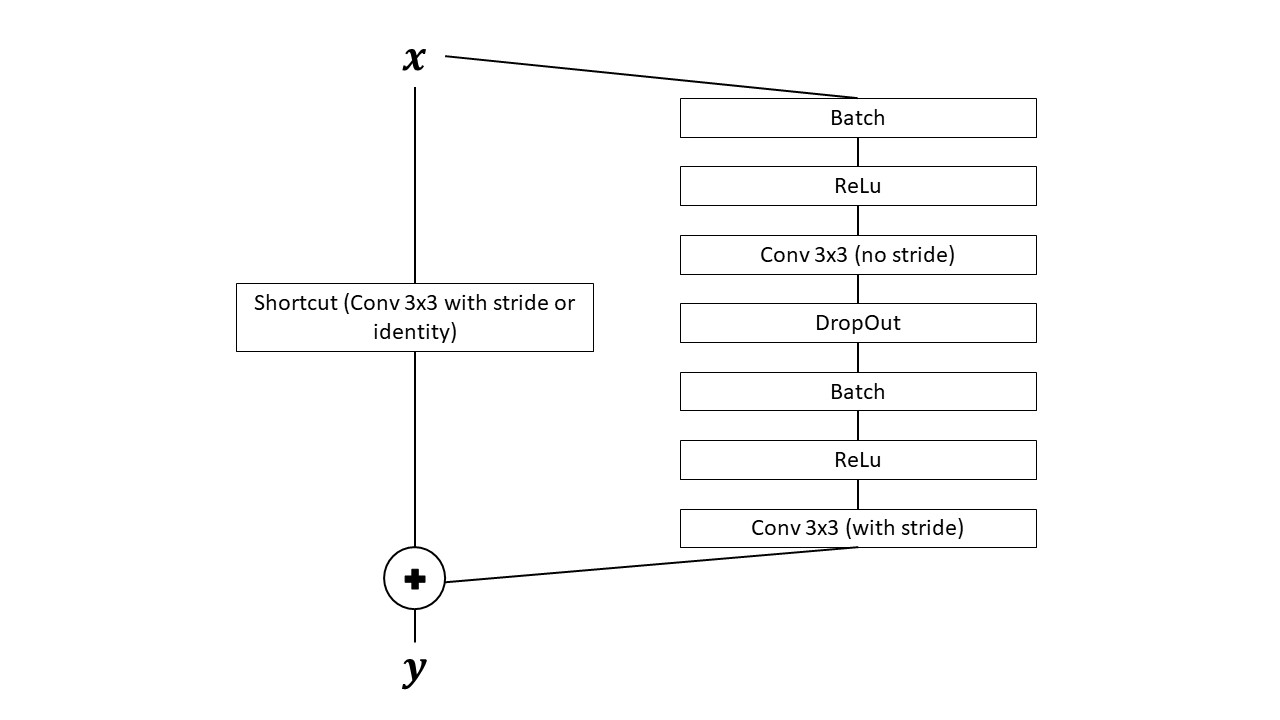
La particularité de cette couche est que l'entrée suit 2 chemins et y subit différentes transformations et que la sortie est donnée par une somme de ces 2 résultats. On crée ensuite des couches WideLayer qui consistent à mettre en série 4 couches WideBasic avec un stride différent sur la première couche WideBasic.

WideResNet consiste à construire un réseau avec la première couche comme une couche de convolution puis d'y mettre plusieurs couches WideLayer et de faire un pooling puis de créer une sortie linéaire (fully connected)


## Q1 : ResNet18

In [ ]:
# Initialize the models

net18_untrained = models.resnet18(weights = None)
net18_untrained = net18_untrained.to(device)
net18_untrained_save = models.resnet18(weights = None) # To save the results
net18_untrained_save = net18_untrained_save.to(device)

net18_pretrained = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
net18_pretrained = net18_pretrained.to(device)
net18_pretrained_save = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) # To save the results
net18_pretrained_save = net18_pretrained_save.to(device)

resized = True # If True, neural network train on resized data
if resized :
    train_loader_resnet = train_loader_resized
    test_loader_resnet = test_loader_resized
    valid_loader_resnet = valid_loader_resized
else :
    train_loader_resnet = train_loader
    test_loader_resnet = test_loader
    valid_loader_resnet = valid_loader

In [ ]:
# Training pretrained model
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

# False if we want to fine the whole model and True if only the last layer
feature_extract = True 

if feature_extract:
    for param in net18_pretrained.parameters():
        param.requires_grad = False

# Reshaping the last layer so output=num_classes
net18_pretrained.fc = nn.Linear(512, num_class).to(device)
net18_pretrained_save.fc = nn.Linear(512, num_class).to(device)

best_acc=0
for epoch in range(num_epochs):

    train(epoch,net18_pretrained,train_loader_resnet)
    acc =test(epoch,net18_pretrained,valid_loader_resnet)
    # Save checkpoint when best model
    if acc > best_acc:
        print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
        net18_pretrained_save.load_state_dict(net18_pretrained.state_dict(), strict=True)
        best_acc=acc


=> Training Epoch #0, LR=0.0100
| Epoch [  0/ 50] Iter[  1/ 32]		Loss: 2.8424 Acc@1: 9.375%
| Epoch [  0/ 50] Iter[ 16/ 32]		Loss: 1.8339 Acc@1: 21.484%
| Epoch [  0/ 50] Iter[ 31/ 32]		Loss: 2.1009 Acc@1: 29.032%

| Validation Epoch #0			Loss: 0.3067 Acc@1: 54.80%
| Saving Best model...			Top1 = 54.80%

=> Training Epoch #1, LR=0.0100
| Epoch [  1/ 50] Iter[  1/ 32]		Loss: 1.2805 Acc@1: 56.250%
| Epoch [  1/ 50] Iter[ 16/ 32]		Loss: 1.4348 Acc@1: 46.289%
| Epoch [  1/ 50] Iter[ 31/ 32]		Loss: 1.7340 Acc@1: 48.488%

| Validation Epoch #1			Loss: 0.3501 Acc@1: 57.30%
| Saving Best model...			Top1 = 57.30%

=> Training Epoch #2, LR=0.0100
| Epoch [  2/ 50] Iter[  1/ 32]		Loss: 1.3812 Acc@1: 50.000%
| Epoch [  2/ 50] Iter[ 16/ 32]		Loss: 1.0855 Acc@1: 53.516%
| Epoch [  2/ 50] Iter[ 31/ 32]		Loss: 1.5918 Acc@1: 54.435%

| Validation Epoch #2			Loss: 0.0939 Acc@1: 56.95%

=> Training Epoch #3, LR=0.0100
| Epoch [  3/ 50] Iter[  1/ 32]		Loss: 1.2050 Acc@1: 59.375%
| Epoch [  3/ 50] Iter[ 1

In [ ]:
# Training not pretrained model
best_acc=0
for epoch in range(num_epochs):


    train(epoch,net18_untrained,train_loader_resnet)
    acc =test(epoch,net18_untrained,valid_loader_resnet)
    # Save checkpoint when best model
    if acc > best_acc:
        print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
        net18_untrained_save.load_state_dict(net18_untrained.state_dict(), strict=True)
        best_acc=acc


=> Training Epoch #0, LR=0.0100
| Epoch [  0/ 50] Iter[  1/ 32]		Loss: 6.7891 Acc@1: 0.000%
| Epoch [  0/ 50] Iter[ 16/ 32]		Loss: 2.4796 Acc@1: 12.891%
| Epoch [  0/ 50] Iter[ 31/ 32]		Loss: 2.1819 Acc@1: 15.827%

| Validation Epoch #0			Loss: 2.1508 Acc@1: 14.05%
| Saving Best model...			Top1 = 14.05%

=> Training Epoch #1, LR=0.0100
| Epoch [  1/ 50] Iter[  1/ 32]		Loss: 2.2679 Acc@1: 12.500%
| Epoch [  1/ 50] Iter[ 16/ 32]		Loss: 1.9343 Acc@1: 23.828%
| Epoch [  1/ 50] Iter[ 31/ 32]		Loss: 2.1441 Acc@1: 25.806%

| Validation Epoch #1			Loss: 1.3202 Acc@1: 27.10%
| Saving Best model...			Top1 = 27.10%

=> Training Epoch #2, LR=0.0100
| Epoch [  2/ 50] Iter[  1/ 32]		Loss: 2.3762 Acc@1: 12.500%
| Epoch [  2/ 50] Iter[ 16/ 32]		Loss: 2.6234 Acc@1: 28.125%
| Epoch [  2/ 50] Iter[ 31/ 32]		Loss: 1.9832 Acc@1: 26.512%

| Validation Epoch #2			Loss: 1.5404 Acc@1: 24.00%

=> Training Epoch #3, LR=0.0100
| Epoch [  3/ 50] Iter[  1/ 32]		Loss: 2.0372 Acc@1: 34.375%
| Epoch [  3/ 50] Iter[ 1

In [ ]:
# Evaluation

# Pretrained
print("Pretrained network")
predicted_concat = test_final(net18_pretrained,test_loader_resnet)

# Not pretrained
print("Not pretrained network")
predicted_concat = test_final(net18_untrained,test_loader_resnet)



Pretrained network

| TEST 			Loss: 0.7712 Acc@1: 67.68%
Not pretrained network

| TEST 			Loss: 2.8787 Acc@1: 35.03%


## Q2 : AlexNet

In [ ]:
# Initialize the models

alexnet_untrained = models.alexnet(weights = None)
alexnet_untrained = alexnet_untrained.to(device)
alexnet_untrained_save = models.alexnet(weights = None) # To save the results
alexnet_untrained_save = alexnet_untrained_save.to(device)

alexnet_pretrained = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
alexnet_pretrained = alexnet_pretrained.to(device)
alexnet_pretrained_save = models.alexnet(weights = None) # To save the results
alexnet_pretrained_save = alexnet_pretrained_save.to(device)

resized = True # If True, neural network train on resized data, has to be True, Alexnet doesn't work en 3x32x32
if resized :
    train_loader_alexnet = train_loader_resized
    test_loader_alexnet = test_loader_resized
    valid_loader_alexnet = valid_loader_resized
else :
    train_loader_resnet = train_loader
    test_loader_alexnet = test_loader
    valid_loader_alexnet = valid_loader

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# Training not pretrained model
best_acc=0
for epoch in range(num_epochs):

    train(epoch,alexnet_untrained,train_loader_alexnet)
    acc =test(epoch,alexnet_untrained,valid_loader_alexnet)
    # Save checkpoint when best model
    if acc > best_acc:
        print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
        alexnet_untrained_save.load_state_dict(alexnet_untrained.state_dict(), strict=True)
        best_acc=acc


=> Training Epoch #0, LR=0.0100
| Epoch [  0/ 50] Iter[  1/ 32]		Loss: 6.9080 Acc@1: 0.000%
| Epoch [  0/ 50] Iter[ 16/ 32]		Loss: 6.7806 Acc@1: 7.812%
| Epoch [  0/ 50] Iter[ 31/ 32]		Loss: 6.5567 Acc@1: 8.871%

| Validation Epoch #0			Loss: 6.2162 Acc@1: 10.00%
| Saving Best model...			Top1 = 10.00%

=> Training Epoch #1, LR=0.0100
| Epoch [  1/ 50] Iter[  1/ 32]		Loss: 6.7318 Acc@1: 21.875%
| Epoch [  1/ 50] Iter[ 16/ 32]		Loss: 5.6802 Acc@1: 9.375%
| Epoch [  1/ 50] Iter[ 31/ 32]		Loss: 4.1497 Acc@1: 9.879%

| Validation Epoch #1			Loss: 15.4427 Acc@1: 10.00%

=> Training Epoch #2, LR=0.0100
| Epoch [  2/ 50] Iter[  1/ 32]		Loss: 5.3559 Acc@1: 3.125%
| Epoch [  2/ 50] Iter[ 16/ 32]		Loss: 3.0532 Acc@1: 8.789%
| Epoch [  2/ 50] Iter[ 31/ 32]		Loss: 2.5765 Acc@1: 8.871%

| Validation Epoch #2			Loss: 2.8715 Acc@1: 10.00%

=> Training Epoch #3, LR=0.0100
| Epoch [  3/ 50] Iter[  1/ 32]		Loss: 2.3702 Acc@1: 9.375%
| Epoch [  3/ 50] Iter[ 16/ 32]		Loss: 2.4468 Acc@1: 9.180%
| Epoch [  

In [ ]:
# Training pretrained model
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

# False if we want to fine the whole model and True if only the last layer
feature_extract = True 

if feature_extract:
    for param in alexnet_pretrained.parameters():
        param.requires_grad = False

# Reshaping the last layer so output=num_classes
alexnet_pretrained.classifier[6] = nn.Linear(4096,num_class).to(device)
alexnet_pretrained_save.classifier[6] = nn.Linear(4096,num_class).to(device)


best_acc=0
for epoch in range(num_epochs):


    train(epoch,alexnet_pretrained,train_loader_alexnet)
    acc =test(epoch,alexnet_pretrained,valid_loader_alexnet)
    # Save checkpoint when best model
    if acc > best_acc:
        print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
        alexnet_pretrained_save.load_state_dict(alexnet_pretrained.state_dict(), strict=True)
        best_acc=acc


=> Training Epoch #0, LR=0.0100
| Epoch [  0/ 50] Iter[  1/ 32]		Loss: 2.3777 Acc@1: 9.375%
| Epoch [  0/ 50] Iter[ 16/ 32]		Loss: 2.2982 Acc@1: 32.812%
| Epoch [  0/ 50] Iter[ 31/ 32]		Loss: 2.1894 Acc@1: 38.105%

| Validation Epoch #0			Loss: 1.9588 Acc@1: 53.65%
| Saving Best model...			Top1 = 53.65%

=> Training Epoch #1, LR=0.0100
| Epoch [  1/ 50] Iter[  1/ 32]		Loss: 2.4289 Acc@1: 43.750%
| Epoch [  1/ 50] Iter[ 16/ 32]		Loss: 1.9938 Acc@1: 49.805%
| Epoch [  1/ 50] Iter[ 31/ 32]		Loss: 1.2662 Acc@1: 49.294%

| Validation Epoch #1			Loss: 0.0544 Acc@1: 52.85%

=> Training Epoch #2, LR=0.0100
| Epoch [  2/ 50] Iter[  1/ 32]		Loss: 2.5108 Acc@1: 50.000%
| Epoch [  2/ 50] Iter[ 16/ 32]		Loss: 1.9043 Acc@1: 53.906%
| Epoch [  2/ 50] Iter[ 31/ 32]		Loss: 3.1376 Acc@1: 51.714%

| Validation Epoch #2			Loss: 3.5198 Acc@1: 54.70%
| Saving Best model...			Top1 = 54.70%

=> Training Epoch #3, LR=0.0100
| Epoch [  3/ 50] Iter[  1/ 32]		Loss: 2.0757 Acc@1: 43.750%
| Epoch [  3/ 50] Iter[ 1

In [ ]:
# Evaluation

# Pretrained
print("Pretrained network")
predicted_concat = test_final(alexnet_pretrained,test_loader_alexnet)

# Not pretrained
print("Not pretrained network")
predicted_concat = test_final(alexnet_untrained,test_loader_alexnet)



Pretrained network

| TEST 			Loss: 3.3919 Acc@1: 62.07%
Not pretrained network

| TEST 			Loss: 1.4141 Acc@1: 38.62%


## Q3 : SVM et RandomForest

In [ ]:
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Set the database in 2D

X_train = []
Y_train = []
X_test = []
Y_test = []

for data in train_loader.dataset :
    X_train.append(data[0])
    Y_train.append(data[1])

for data in test_loader.dataset :
    X_test.append(data[0])
    Y_test.append(data[1])

X_train = torch.cat(X_train)
X_train = X_train.reshape(len(train_loader.dataset),-1)

X_test = torch.cat(X_test)
X_test = X_test.reshape(len(test_loader.dataset),-1)

### SVM

In [ ]:
# SVM (Default OneVersusRest)
from sklearn import svm

parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': np.logspace(-2,1,5),
              'degree': [k for k in range(3,6)],
              'decision_function_shape': ['ovo', 'ovr'],
              }

svc = svm.SVC(kernel = 'rbf', C = 100, decision_function_shape = 'ovr', random_state=seed)
#svc = GridSearchCV(svc, parameters)

svc.fit(X_train, Y_train)

acc = svc.score(X_test, Y_test)

print("\n| TEST on SVM \t\t\tAccuracy: %.2f%%" %(acc*100))
print("Parameters are")
print(svc.get_params())


| TEST on SVM 			Accuracy: 34.04%
Parameters are
{'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 111, 'shrinking': True, 'tol': 0.001, 'verbose': False}


### RandomForest

In [ ]:
# Single tree
clf = tree.DecisionTreeClassifier(criterion = 'gini',max_depth=6, random_state = seed) # Arbre de décision
clf = clf.fit(X_train, Y_train)


# # To see the tree
# print("L'arbre de décision est")
# plt.figure(figsize=(25,20))
# tree.plot_tree(clf,
#                filled=True, rounded=True,
#                class_names = classes)
# print(" ")


# # To cleary see the tree with all nodes :
# import graphviz

# dot_data = tree.export_graphviz(clf, out_file=None) 
# graph = graphviz.Source(dot_data) 

# print("L'arbre de décision est")
# dot_data = tree.export_graphviz(clf, out_file=None, 
#                     #  feature_names=X_train.columns.values,  
#                      class_names=classes,  
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)  
# display(graph)

# Evaluation
acc = clf.score(X_test,Y_test)
print("\n| TEST on a single tree \t\t\tAccuracy: %.2f%%" %(acc*100))


| TEST on a single tree 			Accuracy: 20.46%


In [ ]:
# On a randomforest
clf = ensemble.RandomForestClassifier(criterion = 'gini',n_estimators=1000, random_state = seed)
clf = clf.fit(X_train, Y_train)

# Evaluation
acc = clf.score(X_test,Y_test)
print("\n| TEST on a random forest \t\t\tAccuracy: %.2f%%" %(acc*100))


| TEST on a random forest 			Accuracy: 33.84%


## Q4 : Comparaisons des différents modèles

On donne plusieurs tableaux comparatifs des modèles en fonctions de certains paramètres.

* On remarque que pour le SVM et le RandomForest, au mieux les résultats sont très semblables (autour de 34% de performance) pour une exécution en un temps quasi-similaire également.

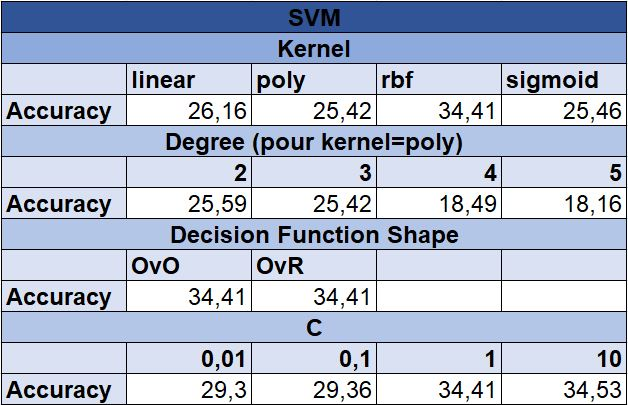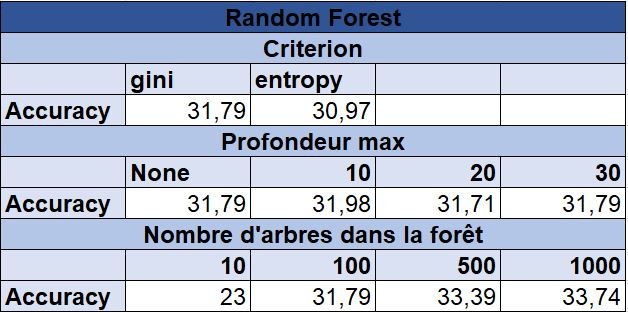

* Pour les réseaux de neurones, on a également crée des dataloaders avec des images de taille 256\*256 pour faire la comparaison avec les 32\*32 mais aussi car AlexNet ne fonctionne pas sur des images de trop petite taille. De plus on remarque que les réseaux préentraînés étaient entraînés sur des images de taille 256\*256. On voit effectivement que changer la taille de l'image a un impact sur la performance des réseaux préentraînés mais ne change rien à ceux qui ne sont pas préentraînés. Enfin le learning rate a un impact sur la performance des réseaux et notamment sur AlexNet qui n'apprenait pas pour un learning rate au dessus de 0.01. On peut le baisser mais jusqu'à un certain seuil, en effet trop le baisser ne le fait pas apprendre assez vite. Enfin les réseaux de neurones avaient un temps d'exécution quasi-similaire et WideResNet 28-2 est celui qui obtenu les meilleurs résultats sur les différents tests.

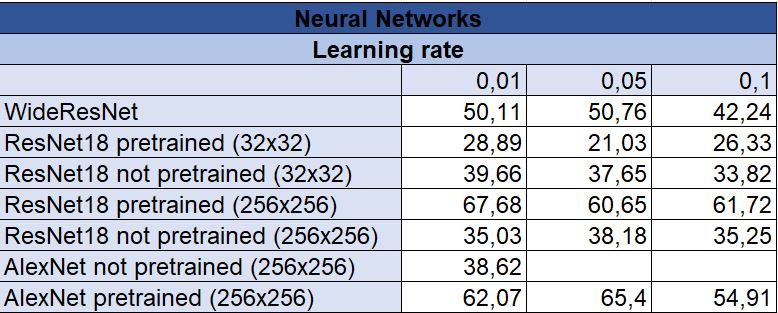


## Q5 : Explications de FixMatch

FixMatch est une méthode d'apprentissage qui a été pensé par Google Reasearch en 2020. Il a été pensé car en DL il est nécessaire d'avoir une grande base de données pour pouvoir effectuer l'apprentissage or créer cette base de données (et surtout poser des labels sur chaque élément) est très coûteux.

FixMatch a été originellement pensé sur la classification d'images à partir de réseaux de neurones tel que ResNet. Imaginons qu'on possède des images avec un label et d'autres non. Le réseau de neurones traditionnel ne peut apprendre que sur les images avec un label or FixMatch est une méthode qui vise également à apprendre sur les données sans label d'où le fait que c'est une méthode d'apprentissage semi-supervisé car il apprend également sur des données non annotées. 

FixMatch utilise la data augmentation, technique utilisée pour augmenter la taille d'une base de données en utilisant des propriétés sur les objets sur lesquels on travaille. Par exemple si on souhaite classifier des images d'animaux, alors effectuer une symétrie horizontale, une faible rotation ou une faible translation ne change que très peu l'image et le réseau de neurones doit être capable de toujours donner le même animal en sortie peu importe le changement sur l'image. On distingue alors deux types de data augmentation :
- **Weak augmentation :** On retrouve des des techniques telle que la symétrie horizontale, la translation, le zoom/dezoom. Ces techniques sont catégorisées comme weak car on ne change qu'assez peu l'image et qu'un bon réseau de neurones entraîné serait capable de classifier l'image avec une accuracy qui varierait assez peu. Dans FixMatch, ils ont choisi de n'utiliser que la symétrie horizontale et des translations (qui ne vont que jusqu'à 12.5% de la taille initiale)
- **Strong augmentation :** Les techniques utilisées effectuent des changements plus drastiques sur l'image et il est bien plus compliqué de classifier l'image, parmi ces techniques on retrouve des changements sur la couleur, le contraste, la luminosité, etc... Parmi les techniques de strong augmentation, FixMatch utilise le CutOut qui consiste à enlever un carré (de taille raisonnable) de l'image. FixMatch effectue également un AutoAugment qui consiste à choisir un certain nombre de transformations parmi un set prédéfini, de choisir une magnitude qui définit la "puissance" de la transformation et d'effectuer ces transformations sur l'image. FixMatch utilise le RandAugment ou le CTAugment pour effectuer l'AutoAugment

L'apprentissage de FixMatch s'effectue en plusieurs étapes :
- Il faut tout d'abord créer la base de données avec des données avec label et des données sans label avec μ fois plus de données sans label que données avec label (il a été prouvé que plus μ est grand, meilleurs sont les résultats). Il faut également choisir une architecture pour les réseaux de neurones.
- On commence à travailler uniquement sur les données ayant un label, la fonction de perte à minimiser est *lₛ* qu'on calcule à l'aide de l'entropie croisée
- Après avoir fait cette étape, on va effectuer une weak augmentation sur les données sans label. Et on va demander au réseau de neurones de classifier les images. Si la classification est donnée avec une certaine confiance supérieuse à un seuil (pour éviter d'avoir des pseudo label aberrant), on va poser un pseudo-label sur l'image en fonction de ce qu'a donné le réseau de neurones.
- On va maintenant effectuer une strong augmentation sur les données avec un pseudo-label et demander au réseau de neurones de classifier les images qui ont subi cette augmentation. A partir du pseudo label et de la sortie, on détermine l'entropie croisée et la fonction de perte *lᵤ*  uniquement sur les données ayant un pseudo label
- On calcule la fonction de perte totale *lₛ + λᵤlᵤ* avec *λᵤ* un paramètre de régularisation (qui sera fixé contrairement à d'autres algorithmes de SSL). A partir de cette fonction, on va remettre à jour les poids

Le fait d'introduire un seuil pour créer le pseudo label fait qu'au début le réseau de neurones ne pourra mettre aucun pseudo label sur les images. Donc au début l'entraînement s'effectuera comme si on entrainait traditionnellement un réseau de neurones sur des des données avec label, puis petit à petit il va être capable de créer quelques pseudo label et ainsi les données sans label vont commencer à avoir de plus en plus d'impact sur les poids du réseau


## Q6 : Implémentation de FixMatch

On choisit un réseau de neurones WideResNet 28-2 comme dans le papier originel (https://arxiv.org/ftp/arxiv/papers/2001/2001.07685.pdf)

On commence par définir tous les hyperparamètres qu'on devra utiliser (les valeurs seront prises à l'identique au papier originel)

On va utiliser 100 images avec label par classe (on peut choisir une autre valeur mais il faudra reconstruire les données avec label qu'on a fait au tout début). On possède donc 1000 images avec label et 47000 images sans label

In [ ]:
# Parameters

num_class = 10 #number of classes
seed=111 #seed for the algorithm
batch_size = 32
num_train = 100 # number of labeled image by classe
cutout = 16  # parameter for the cutout
num_epochs = 100
#Validation set size
valid_size = 200

threshold = 0.95 # Threshold to set pseudo label = tau
lambda_u = 1 # scalar that decides how much both the unlabeled image loss contribute relative to the labeled loss
mu = 7 # Relative size between labeled and unlabeled data
lr = 0.03 # Learning rate
bn_momentum = 0.9 # Used in the BatchNorm2D layer in WideResNet
momentum = 0.9 # In SGD optimizer
weight_decay = 5e-4 # In SGD optimizer
nesterov = True # In SGD optimizer

criterion = nn.CrossEntropyLoss()
torch.manual_seed(seed) # Set the seed

On définit les différentes transformations qu'on fera subir à nos données (weak, strong augmentation), on construit les dataloader ainsi qu'une fonction **unlabeled_loader** qui permettra de créer 2 dataloader à partir dun set d'images: un pour le weak augmentation et l'autre pour le strong augmentation (les images sont dans un ordre aléatoire mais dans le même ordre pour les 2 dataloader ce qui nous permettra d'itérer sur chacun des dataloader à chaque étape de l'algorithme)

In [ ]:
# Create shuffled dataloader with weak and strong augmentation
def unlabeled_loader(x_unlabeled, y_unlabeled, seed = None) :
    if seed==None :
        permutation = np.random.permutation(len(x_unlabeled))
    else :
        permutation = np.random.RandomState(seed=seed).permutation(len(x_unlabeled))
    x_unlabeled = x_unlabeled[permutation]
    x_unlabeled = x_unlabeled[:len(x_train)*mu]
    y_unlabeled = y_unlabeled[permutation]
    y_unlabeled = y_unlabeled[:len(x_train)*mu]
    unlabeled_loader_weak = torch.utils.data.DataLoader(
        Dataset_sub_CIFAR(x_unlabeled, y_unlabeled, transform=transform_weak),
        batch_size=batch_size*mu,shuffle=False, num_workers=2) 
    
    unlabeled_loader_strong = torch.utils.data.DataLoader(
        Dataset_sub_CIFAR(x_unlabeled, y_unlabeled, transform=transform_strong),
        batch_size=batch_size*mu,shuffle=False, num_workers=2) 
    return unlabeled_loader_weak, unlabeled_loader_strong


#Dataset loading
CIFAR10_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=None, download=True)
CIFAR10_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=None, download=True)
np.random.seed(seed=seed)
permuation=np.random.permutation(len(CIFAR10_train_dataset.targets))

Original_train_data_x = (CIFAR10_train_dataset.data)
Original_train_data_y = np.array(CIFAR10_train_dataset.targets)
Original_train_data_x = Original_train_data_x[permuation]
Original_train_data_y = Original_train_data_y[permuation]

Original_test_data_x = CIFAR10_test_dataset.data
Original_test_data_y = np.array(CIFAR10_test_dataset.targets)



#Selection of 250 labeled images for training and 2000 for validation
incr_class = torch.zeros(num_class)
train_idx_dico = {} #labeled images index dictionnary

for i in range(num_class):
    train_idx_dico[str(i)] = []

valid_idx = np.zeros(num_class * valid_size, dtype=np.int32) #validation images indexes (2000)
incr_t = 0
incr_v = 0
incrtotal = 0

for idx in range(len(Original_train_data_y)):
    class_y = Original_train_data_y[idx]
    incrtotal += 1

    train_idx_dico[str(class_y)].append(idx)
    incr_class[class_y] += 1 #count the number of image per class
    incr_t += 1


train_idx = np.zeros(num_class * num_train, dtype=np.int32) #train labeled images indexes (1000)
list_train_id = []
list_unalabel_id = []
valid_idx = []
unlabel_idx_dico = {}
for i in range(num_class):
    unlabel_idx_dico[str(i)] = []
for i in range(num_class):
    list_train_id = list_train_id + train_idx_dico[str(i)][0:num_train]
    valid_idx =valid_idx + train_idx_dico[str(i)][num_train:num_train+valid_size]
    list_unalabel_id = list_unalabel_id + train_idx_dico[str(i)][num_train+valid_size::]
    unlabel_idx_dico[str(i)] = train_idx_dico[str(i)][num_train::]

#Get labeled and unlabeled data

x_train = Original_train_data_x[[int(i) for i in list_train_id]]
y_train = Original_train_data_y[[int(i) for i in list_train_id]]

x_unlabeled = Original_train_data_x[[int(i) for i in list_unalabel_id]]
y_unlabeled = Original_train_data_y[[int(i) for i in list_unalabel_id]]

#Get validation set data
x_valid = Original_train_data_x[[int(i) for i in valid_idx]]
y_valid = Original_train_data_y[[int(i) for i in valid_idx]]

# Printing the size of the training, validation and test sets
print('Number of training examples: ' + str(x_train.shape[0]))
print('Number of unlabeled examples: ' + str(x_unlabeled.shape[0]))
print('Number of validation examples: ' + str(x_valid.shape[0]))

transform_weak = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode = 'reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

# We choose to use RandAugment
transform_strong = transforms.Compose([
    transforms.RandAugment(),
    transforms.ToTensor(),
    CutoutDefault(cutout),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

transform_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

# Dataloader creation

labeled_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_train, y_train, transform=transform_normalize),
    batch_size=batch_size,shuffle=True, num_workers=2) #num_workers = 2 ou 1

test_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(Original_test_data_x, Original_test_data_y, transform=transform_normalize),
    batch_size = batch_size,
    shuffle=False, num_workers=2)

valid_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_valid, y_valid, transform= transform_normalize),
    batch_size=batch_size,
    shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 1000
Number of unlabeled examples: 47000
Number of validation examples: 2000


On crée le réseau de neurones qui est un WideResNet 28-2

On crée également la fonction d'entraînement. Cette dernière affichera en plus des performances et de la fonction de perte, des informations sur le nombre de pseudo label posé sur les images sans label (plus ce nombre est grand plus le réseau est "confiant" dans ses prédictions), le nombre de pseudo labels correct (information qu'on ne devrait pas avoir mais qu'on dispose ici et qui permet de voir la performance du réseau de neurones sur des données) ainsi que le nombre de fois où le réseau de neurones donne la même sortie pour une image avec une strong augmentation que son pseudo label (cela mesure sa consistance)

In [ ]:
#Networks creation
net = WideResNet(28, 2, dropout_rate=0.0, num_classes=num_class)
net = net.to(device)
net_save = WideResNet(28, 2, dropout_rate=0.0, num_classes=num_class) # model where to save the results
net_save = net_save.to(device)

# Training
def train_fixmatch(epoch,net,trainloader,log_interval=15):
    net.train()
    correct_train = 0
    total_train = 0

    total_pseudo_label = 0 # nb of unlabeled images
    nb_pseudo_label = 0 # nb of pseudo label (higher than threshold)
    same_pseudo_label = 0 # nb of same output between weak and strong augment
    correct_pseudo_label = 0 # correct pseudo label

    print('\n=> Training Epoch #%d, LR=%.4f' %(epoch, learning_rate_scheduler(lr, epoch)))
    optimizer = optim.SGD(net.parameters(), lr=learning_rate_scheduler(lr, epoch), momentum=momentum, weight_decay=weight_decay, nesterov = nesterov)

    unlabeled_loader_weak, unlabeled_loader_strong = unlabeled_loader(x_unlabeled, y_unlabeled, seed=epoch)
    iterator_strong = iter(unlabeled_loader_strong)
    iterator_weak = iter(unlabeled_loader_weak)
    for batch_idx, (inputs_train, targets_train) in enumerate(trainloader):
        optimizer.zero_grad()
        # Labeled inputs
        inputs_train, targets_train = inputs_train.to(device), targets_train.to(device) # GPU settings
        inputs_train, targets_train = Variable(inputs_train), Variable(targets_train)
        outputs_train = net(inputs_train)               # Forward Propagation

        # Get pseudo label
        inputs_weak, targets_weak = next(iterator_weak)
        inputs_weak = inputs_weak.to(device)
        targets_weak = targets_weak.to(device)
        outputs_weak = net(inputs_weak)
        outputs_weak = nn.Softmax(dim=1)(outputs_weak) # Softmax = Normalization -> To get probabilities so it can be compared to threshold
        outputs_weak_max, pseudo_label = outputs_weak.max(dim=1) # Get max and pseudo label

        mask_targets = outputs_weak_max>threshold # Used to know if we take the pseudo label in the loss, mask on targets
        mask_inputs = mask_targets.view(-1,1) # Mask on inputs/outputs

        # Strong augmentation (only on pseudo label higher than the threshold)
        inputs_strong, _ = next(iterator_strong)
        inputs_strong = inputs_strong.to(device)
        inputs_strong = Variable(inputs_strong)
        pseudo_label = Variable(pseudo_label)
        outputs_strong = net(inputs_strong)


        # Loss and backpropagation
        outputs_strong_masked = (torch.masked_select(outputs_strong, mask_inputs)).view(-1, num_class)
        pseudo_label_masked = torch.masked_select(pseudo_label, mask_targets)
        targets_weak_masked = torch.masked_select(targets_weak, mask_targets)
        # loss_u = loss on unlabeled
        if outputs_strong_masked.numel() > 0 :
            loss_u = criterion(outputs_strong_masked, pseudo_label_masked)
        else :
            loss_u = 0
        loss = criterion(outputs_train, targets_train) + lambda_u * loss_u # Loss
        loss.backward()  # Backward Propagation
        optimizer.step() # Optimizer update


        _, predicted_train = torch.max(outputs_train.data, 1)
        correct_train += predicted_train.eq(targets_train.data).cpu().sum()
        total_train += targets_train.size(0)

        total_pseudo_label += mask_inputs.size(0)
        nb_pseudo_label += mask_inputs.cpu().sum()
        _, predicted_strong = torch.max(outputs_strong_masked.data, 1)
        correct_pseudo_label += pseudo_label_masked.eq(targets_weak_masked.data).cpu().sum()
        same_pseudo_label += predicted_strong.eq(pseudo_label_masked.data).cpu().sum()
        if batch_idx % log_interval == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%% \nPseudo labeled: %.3f%% (%d/%d)    \tCorrect pseudo label: %s (%d/%d)    \tSame output weak and strong augmentation: %s (%d/%d)'
                %(epoch, num_epochs, batch_idx+1,
                    (len(trainloader.dataset)//batch_size)+1, loss.item(), 100.*correct_train/total_train,
                    100.*nb_pseudo_label/total_pseudo_label, nb_pseudo_label, total_pseudo_label,
                  ('{:.2f}%'.format(100.*correct_pseudo_label/nb_pseudo_label) if nb_pseudo_label!=0 else 'Undefined'), correct_pseudo_label, nb_pseudo_label,
                  ('{:.2f}%'.format(100.*same_pseudo_label/nb_pseudo_label) if nb_pseudo_label!=0 else 'Undefined'), same_pseudo_label, nb_pseudo_label))

### Entraînement et évaluation

In [ ]:
best_acc=0
for epoch in range(num_epochs):

    train_fixmatch(epoch,net,labeled_loader)
    acc =test(epoch,net,valid_loader)
    # Save checkpoint when best model
    if acc > best_acc:
        print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
        net_save.load_state_dict(net.state_dict(), strict=True)
        best_acc=acc


=> Training Epoch #0, LR=0.0300
| Epoch [  0/100] Iter[  1/ 32]		Loss: 2.3109 Acc@1: 9.375% 
Pseudo labeled: 0.000% (0/224)    	Correct pseudo label: Undefined (0/0)    	Same output weak and strong augmentation: Undefined (0/0)
| Epoch [  0/100] Iter[ 16/ 32]		Loss: 2.1104 Acc@1: 17.969% 
Pseudo labeled: 0.000% (0/3584)    	Correct pseudo label: Undefined (0/0)    	Same output weak and strong augmentation: Undefined (0/0)
| Epoch [  0/100] Iter[ 31/ 32]		Loss: 1.7244 Acc@1: 21.976% 
Pseudo labeled: 0.000% (0/6944)    	Correct pseudo label: Undefined (0/0)    	Same output weak and strong augmentation: Undefined (0/0)

| Validation Epoch #0			Loss: 2.1608 Acc@1: 22.70%
| Saving Best model...			Top1 = 22.70%

=> Training Epoch #1, LR=0.0300
| Epoch [  1/100] Iter[  1/ 32]		Loss: 2.1796 Acc@1: 21.875% 
Pseudo labeled: 0.000% (0/224)    	Correct pseudo label: Undefined (0/0)    	Same output weak and strong augmentation: Undefined (0/0)
| Epoch [  1/100] Iter[ 16/ 32]		Loss: 1.8590 Acc@1: 2

In [ ]:
test_final(net, test_loader)


| TEST 			Loss: 2.3513 Acc@1: 65.94%


array([3, 1, 8, ..., 5, 1, 7])

# Q7 :
Pour éviter le surapprentissage en Deep Learning on peut limiter la taille de nos architectures utilisés en fonction de la taille des données d'entraînement : pour les arbres de décisions on limite la profondeur des arbres, pour les réseaux de neurones on limite le nombre de neurones. Avec une architecture trop grande, on peut apprendre par coeur une base de données. On peut aussi utiliser un paramètre de régularisation pour contrôler le surapprentissage. Une dernière possibilité serait d'utiliser des données sans label pendant l'entraînement comme ça a été fait dans FixMatch, le réseau de neurones ne peut apprendre ces données par coeur étant donné qu'il ne sait pas quelle sortie il doit obtenir sur ces données.